This is another baseline model named $LSA_{T}-DeBERTa$ proposed in the paper [Modeling Aspect Sentiment Coherency via Local Sentiment Aggregation](https://aclanthology.org/2024.findings-eacl.13.pdf) which we have adopted to compare againist our proposed model. The authors of this paper built a model based on DeBERTa model with novel local sentiment aggregation (LSA) to the model. In LSA, the model extracts each individual apsects of the sentences and builts sentiment aggregation window. In this particular case of $LSA_T$ the model is employing local context focus-based aspect features.

In [2]:

## Loading all the required libraries
import pandas as pd
import copy
import numpy as np
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
## As we are running in GPU. So we are initializing for the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
## Loading the dataset and splitting the test dataset for later
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[:1803].reset_index( drop = True)

In [6]:
## As we doing predicting modelling by predicting rating of the each movie. So setting the numclasses to 1
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, ignore_mismatched_sizes = True)

In [7]:
## Customized dataset loader class for loading the dataset
class SubtitlesDataset(Dataset):
    def __init__(self, texts, labels_regression, tokenizer, max_length):
        self.texts = texts
        self.labels_regression = labels_regression
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label_regression = float(self.labels_regression[idx])

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        #print("encoding :", encoding)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        token_type_ids = encoding['token_type_ids'].squeeze()

        return input_ids, attention_mask, token_type_ids, label_regression

In [10]:
## In this code cell we are splitting the train and validation datasets
texts = df['subtitles'].tolist()
labels_regression = df['Language'].tolist()

train_texts, val_texts, train_labels_regression, val_labels_regression = train_test_split(texts, 
                                                                                          labels_regression, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

In [11]:
## By utilizing the dataloader class above we are creating train and validation dataloaders
train_dataset = SubtitlesDataset(train_texts, train_labels_regression, tokenizer, max_length=128)
val_dataset = SubtitlesDataset(val_texts, val_labels_regression, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [16]:
## Loading the model to GPU
model = model.to(device)

## Initializing the hyperparameters and lists for storing train and validation losses
optimizer = torch.optim.AdamW(model.parameters(), lr=2.2908675418875646e-06)
num_epochs = 25
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    ## Training MODE
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_id, attention_masks, token_ids, labels = batch
        input_id = input_id.to(device)
        attention_masks = attention_masks.to(device)
        token_ids = token_ids.to(device)
        labels = labels.long().to(device)
        regression_output = model(input_id, attention_masks, token_ids)
        labels_regression = labels.float()
        regression_output = regression_output.logits.squeeze(-1)
        loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    ## Evaluation Mode
    model.eval()
    total_val_loss = 0


    with torch.no_grad():
        for batch in val_loader:
            input_id, attention_masks, token_ids, labels = batch
            input_id = input_id.to(device)
            attention_masks = attention_masks.to(device)
            token_ids = token_ids.to(device)
            labels = labels.long().to(device)
            
            regression_output = model(input_id, attention_masks, token_ids)
            labels_regression = labels.float()
            regression_output = regression_output.logits.squeeze(-1)
            val_loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    ## Printing Training and Validation
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

  4%|████▉                                                                                                                       | 1/25 [01:34<37:58, 94.95s/it]

Epoch 1/25, Training Loss: 24.8045, Validation Loss: 17.0506


  8%|█████████▉                                                                                                                  | 2/25 [03:14<37:21, 97.48s/it]

Epoch 2/25, Training Loss: 14.7039, Validation Loss: 10.1041


 12%|██████████████▉                                                                                                             | 3/25 [04:52<35:49, 97.72s/it]

Epoch 3/25, Training Loss: 9.5329, Validation Loss: 7.2960


 16%|███████████████████▊                                                                                                        | 4/25 [06:31<34:22, 98.20s/it]

Epoch 4/25, Training Loss: 7.5661, Validation Loss: 7.2077


 20%|████████████████████████▊                                                                                                   | 5/25 [08:08<32:36, 97.82s/it]

Epoch 5/25, Training Loss: 7.6365, Validation Loss: 8.0249


 24%|█████████████████████████████▊                                                                                              | 6/25 [09:46<30:59, 97.85s/it]

Epoch 6/25, Training Loss: 7.6888, Validation Loss: 7.2431


 28%|██████████████████████████████████▋                                                                                         | 7/25 [11:23<29:16, 97.61s/it]

Epoch 7/25, Training Loss: 7.5854, Validation Loss: 7.0947


 32%|███████████████████████████████████████▋                                                                                    | 8/25 [13:01<27:42, 97.82s/it]

Epoch 8/25, Training Loss: 7.4891, Validation Loss: 7.4404


 36%|████████████████████████████████████████████▋                                                                               | 9/25 [14:38<26:01, 97.62s/it]

Epoch 9/25, Training Loss: 7.7318, Validation Loss: 7.9460


 40%|█████████████████████████████████████████████████▏                                                                         | 10/25 [16:17<24:29, 97.95s/it]

Epoch 10/25, Training Loss: 7.6279, Validation Loss: 7.0521


 44%|██████████████████████████████████████████████████████                                                                     | 11/25 [17:55<22:51, 97.99s/it]

Epoch 11/25, Training Loss: 7.7784, Validation Loss: 7.2818


 48%|███████████████████████████████████████████████████████████                                                                | 12/25 [19:28<20:55, 96.59s/it]

Epoch 12/25, Training Loss: 7.6643, Validation Loss: 7.0507


 52%|███████████████████████████████████████████████████████████████▉                                                           | 13/25 [21:05<19:20, 96.71s/it]

Epoch 13/25, Training Loss: 7.6685, Validation Loss: 8.1230


 56%|████████████████████████████████████████████████████████████████████▉                                                      | 14/25 [22:43<17:47, 97.02s/it]

Epoch 14/25, Training Loss: 8.1529, Validation Loss: 8.2561


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 15/25 [24:21<16:12, 97.28s/it]

Epoch 15/25, Training Loss: 7.7211, Validation Loss: 7.0767


 64%|██████████████████████████████████████████████████████████████████████████████▋                                            | 16/25 [25:59<14:37, 97.45s/it]

Epoch 16/25, Training Loss: 7.6762, Validation Loss: 7.4234


 68%|███████████████████████████████████████████████████████████████████████████████████▋                                       | 17/25 [27:38<13:03, 97.91s/it]

Epoch 17/25, Training Loss: 8.2706, Validation Loss: 7.4744


 72%|████████████████████████████████████████████████████████████████████████████████████████▌                                  | 18/25 [29:16<11:24, 97.84s/it]

Epoch 18/25, Training Loss: 7.7651, Validation Loss: 7.0404


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▍                             | 19/25 [30:53<09:47, 97.84s/it]

Epoch 19/25, Training Loss: 7.5861, Validation Loss: 7.8950


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 20/25 [32:32<08:10, 98.03s/it]

Epoch 20/25, Training Loss: 8.2433, Validation Loss: 8.7311


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 21/25 [34:09<06:31, 97.91s/it]

Epoch 21/25, Training Loss: 8.3364, Validation Loss: 7.9441


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 22/25 [35:48<04:54, 98.06s/it]

Epoch 22/25, Training Loss: 7.6369, Validation Loss: 7.0816


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 23/25 [37:25<03:15, 97.88s/it]

Epoch 23/25, Training Loss: 7.5489, Validation Loss: 7.2217


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 24/25 [39:03<01:37, 97.71s/it]

Epoch 24/25, Training Loss: 8.1023, Validation Loss: 7.6245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [40:42<00:00, 97.69s/it]

Epoch 25/25, Training Loss: 8.2459, Validation Loss: 7.4912


In [11]:
# time took to run 40:42

In [20]:
## Storing the Loss values in dictionary for creating and storing the results in the dataframe
data = {'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses}
df2 = pd.DataFrame(data)
excel_filename = "losses_per_epoch2_deberta.xlsx"
df2.to_excel(excel_filename, index=False)
print("Train and Validation Losses per Epoch saved to:", excel_filename)

Train and Validation Losses per Epoch saved to: losses_per_epoch2_deberta.xlsx


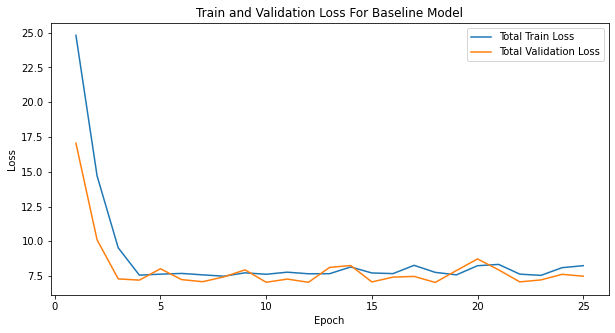

In [23]:
## Plotting the Loss values
df_excel=pd.read_excel("./losses_per_epoch2_deberta.xlsx")
plt.figure(figsize = (10, 5))
plt.plot(range(1, 26), df_excel['Train Loss'].tolist(), label='Total Train Loss')
plt.plot(range(1, 26), df_excel['Validation Loss'].tolist(), label='Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss For Baseline Model')
plt.legend()

plt.savefig("baseline_model_losses_baseline2.pdf")
plt.show()

In [24]:
## Minimum Validataion loss
min(val_losses)

7.040414492289226

In [ ]:
## Storing and Loading the model for future doing inference
# torch.save(model.state_dict(), 'models/baseline_lsa-DeBERTa(baseline1).pth')
# model = Bert_Attention(numclasses, device).to(device)
# model.load_state_dict(torch.load('models/baseline_lsa-DeBERTa(baseline1).pth'))

In [26]:
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[1803:].reset_index( drop = True)

predictions=[]
for sub in tqdm(df.subtitles):
    inputs = tokenizer(sub, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    # Get input_ids and attention_mask from the tokenizer output
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    token_ids = inputs['token_type_ids']

    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    token_ids = token_ids.to(device)
    labels = labels.long().to(device)
    
    with torch.no_grad():
        regression_output = model(input_ids, attention_masks, token_ids)
        predicted_score = regression_output.logits
        predicted_score = list(set([x.item() for x in predicted_score]))[0]#regression_output.logits
    predictions.append(predicted_score)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [01:05<00:00,  3.05it/s]


In [36]:
## Evaluating the performance of the model and printing the results
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
df_predictions=pd.DataFrame({ 'Language_Score':df['Language'].tolist(),"Predcited_Score":predictions})
true_labels = np.array(df_predictions['Language_Score'].tolist())
predicted_scores=np.array(df_predictions['Predcited_Score'].tolist())
mse = mean_squared_error(true_labels, predicted_scores)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predicted_scores)
r2 = r2_score(true_labels, predicted_scores)
evs = explained_variance_score(true_labels, predicted_scores)

print("mse: ",mse)
print("rmse: ",rmse)
print("mae: ",mae)
print("r2: ",r2)
print("evs: ",evs)

mse:  8.505554643742947
rmse:  2.9164284053861063
mae:  2.349168504648541
r2:  -0.09532114813423997
evs:  1.0481554292285367e-06
